In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from gnnco import BatchedDenseGraphs, BatchedSignals, DenseGraph
from gnnco.chem import smiles_to_graph
from gnnco.models import GAT
from gnnco.random import erdos_renyi, bernoulli_corruption
from gnnco.visualisation import plot_similarities, plot_graph
from safetensors.torch import load_model

In [2]:
model = GAT(6, 16, 128, 128)
load_model(
    model,
    "/home/jlagesse/gnnco/mlruns/898442121550368682/fda9fc47431b4266818d7c27c0aaac94/artifacts/checkpoint.safetensors",
)

(set(), [])

In [3]:
g = BatchedDenseGraphs.from_graphs(
    [smiles_to_graph("C1=CC=C2C(=C1)NC(=N2)C3=CSC=N3")]
).to_sparse()
# g = erdos_renyi(1, 100, 0.08).to_sparse()
batch = g
g = g[0]
adjacency_matrix = g.adj()
signal = BatchedSignals(torch.ones((g.order(), 1)), torch.LongTensor([0]))
out = model(signal, batch)._signals

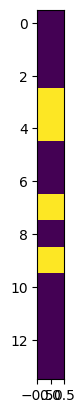

In [5]:
plt.imshow(adjacency_matrix.numpy().sum(axis=1).reshape(14,1))

In [24]:
pair_g = BatchedDenseGraphs.from_graphs(
    [DenseGraph(adjacency_matrix=torch.logical_not(torch.eye(2, dtype=torch.bool)))]
).to_sparse()
# g = erdos_renyi(1, 20, 0.4).to_sparse()
pair_batch = pair_g
pair_g = pair_g[0]
pair_adjacency_matrix = pair_g.adj()
pair_signal = BatchedSignals(torch.ones((pair_g.order(), 1)), torch.LongTensor([0]))
pair_out = model(pair_signal, pair_batch)._signals

In [25]:
y = torch.zeros((100,100))

for i in range(100):
    for j in range(100):
        y[i,j] = (out[i]*pair_out[0]).sum() + (out[j]*pair_out[0]).sum()

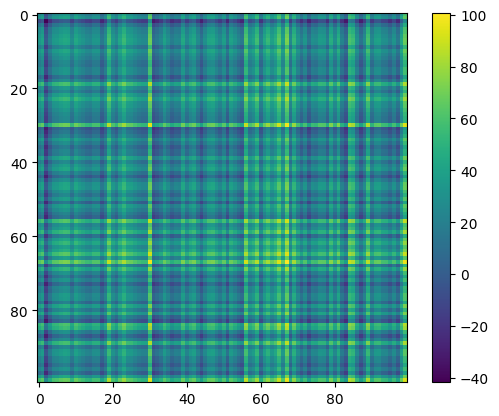

In [26]:
im = plt.imshow(y.detach().numpy())
plt.colorbar(im)

In [22]:
out = model(signal, batch)._signals

In [23]:
similarity_matrix = out @ out.T

In [24]:
similarity_matrix.shape

torch.Size([14, 14])

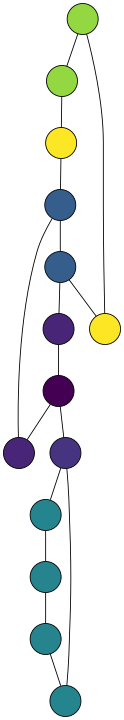

In [25]:
plot_similarities(g, 2, similarity_matrix, size=10)

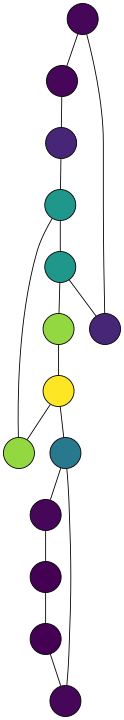

In [26]:
plot_similarities(g, 7, similarity_matrix, size=10)

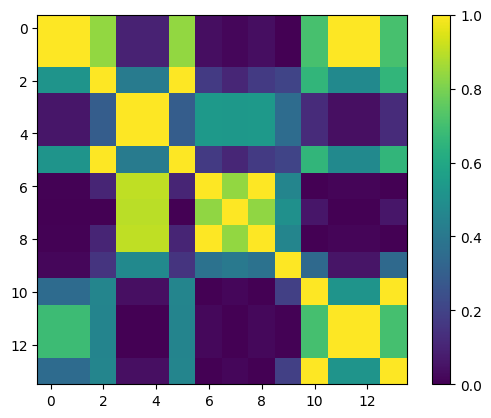

In [27]:
s = similarity_matrix.detach().cpu().numpy()
m = np.min(s, axis=1)
mm = np.max(s, axis=1)
im = plt.imshow((s - m) / (mm - m))
plt.colorbar(im)

In [28]:
np.argmax(s, axis=0)

array([ 0,  0,  2,  3,  3,  2,  6,  7,  6,  9, 10,  0,  0, 10])

In [29]:
g = erdos_renyi(1, 6, 0.4)
perturbated_g = bernoulli_corruption(g, 0.04, 0.00)
batch = g.to_sparse()
perturbated_batch = perturbated_g.to_sparse()
g = g[0].to_sparse()
perturbated_g = perturbated_g[0].to_sparse()

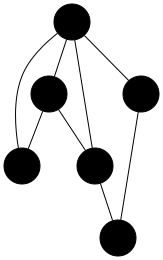

In [30]:
plot_graph(g)

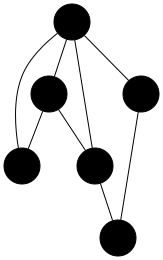

In [31]:
plot_graph(perturbated_g)

In [32]:
signal = BatchedSignals(torch.ones((g.order(), 1)), torch.LongTensor([0]))
out1 = model(signal, batch)._signals
out2 =  model(signal, perturbated_batch)._signals

In [33]:
similarity_matrix = out1 @ out2.T

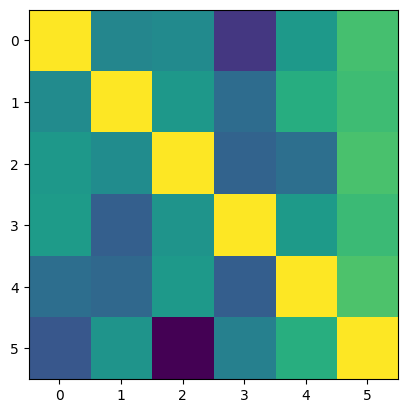

In [34]:
s = (torch.eye(6) - 0.2*torch.randn((6,6))**2).detach().cpu().numpy()
m = np.min(s, axis=1)
mm = np.max(s, axis=1)
im = plt.imshow((s - m) / (mm - m))
# plt.colorbar(im)